# Import Libraries

In [55]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # install dependencies


In [56]:
import torch
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

# Utility Functions

In [57]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img


In [58]:

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array , 'RGBA') 
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# Import pretrained Model

## YOLOv5


In [59]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.to(device);

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-24 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


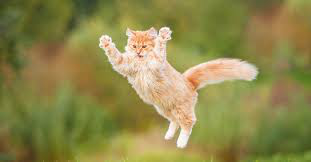

In [ ]:
test_img = PIL.Image.open("/content/images.jpg")
test_img

In [ ]:
# Define the transformations
transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((480, 640)),  # Resize the image to 256x256 pixels
    transforms.ToTensor()          # Convert the image to a PyTorch tensor
])

test_img_tensor = transform(test_img)
test_img_tensor.shape

torch.Size([3, 480, 640])

In [ ]:
output = model(test_img)
output.xyxy

[tensor([[ 98.46108,  25.92426, 256.87872, 145.19278,   0.53891,  15.00000],
         [ 98.93700,  26.00698, 257.05417, 147.28709,   0.34040,  14.00000]])]

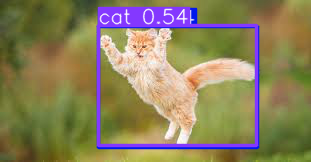

In [ ]:
output.show()

In [ ]:
torch.tensor(plt.imread("/content/images.jpg")).shape

torch.Size([162, 311, 3])

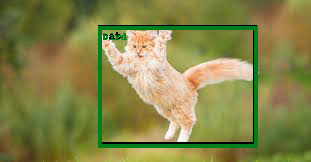

In [ ]:
transform = transforms.ToPILImage()

transform(draw_bounding_boxes(torch.tensor(plt.imread("/content/images.jpg")).permute(2,0,1).type(torch.uint8) ,
                              output.xyxy[0][:,:4 ],
                              labels=["cat","bird"],
                              width = 4,
                              font_size=10
                              )
                              
                              )

# Start stream capturing

In [60]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((480, 640)), 
#     transforms.ToTensor()          # Convert the image to a PyTorch tensor
# ])

# model(transform(img_tensor).unsqueeze(0)).shape

torch.Size([1, 18900, 85])

In [ ]:


# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty



bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    

    img_pil = PIL.Image.fromarray(img)

    outputs = model(img_pil)
    
    # # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    
   



    # # # get face bounding box for overlay
    for (x,y,w,h , _ ,_) in outputs.xywh[0]:
      x = int(x.item() - x.item()  // 2  )
      y = int(y.item() - y.item() //  2)
      w = int(w.item())
      h = int(h.item())



      # print(bbox_array.shape , type(bbox_array),x , y ,w ,h )
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)


      ## create text 
      # Draw text on the image
      text = outputs.crop(0)[0]["label"]
      font = cv2.FONT_HERSHEY_SIMPLEX
      font_scale = 0.5
      thickness = 2
      color = (0, 0, 255) # BGR format
      text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
      text_x = (bbox_array.shape[1] - text_size[0]) // 2
      text_y = (bbox_array.shape[0] + text_size[1]) // 2
      cv2.putText(bbox_array, text, (x, y), font, font_scale, color, thickness);



    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255







    # # # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
     

# Discovering how to work with images from js

In [ ]:
x , y ,w ,h = 10.5 , 10 , 200 ,400
bbox_array = np.zeros([480,640,4], dtype=np.uint8)
bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
image = PIL.Image.fromarray(bbox_array[:,:,0])

image.show()

In [ ]:
for i in range(3):
  print(bbox_array[:,:,i].sum())

916980
0
0


In [52]:
outputs.crop(0)

[{'box': [tensor(39.37390, device='cuda:0'),
   tensor(4.39458, device='cuda:0'),
   tensor(626.73969, device='cuda:0'),
   tensor(477.03809, device='cuda:0')],
  'conf': tensor(0.71129, device='cuda:0'),
  'cls': tensor(0., device='cuda:0'),
  'label': 'person 0.71',
  'im': array([[[177, 173, 172],
          [184, 180, 179],
          [184, 180, 179],
          ...,
          [164, 160, 159],
          [164, 160, 159],
          [166, 160, 162]],
  
         [[177, 173, 172],
          [184, 180, 179],
          [184, 180, 179],
          ...,
          [162, 161, 159],
          [164, 160, 159],
          [166, 160, 162]],
  
         [[177, 173, 172],
          [183, 179, 178],
          [183, 179, 178],
          ...,
          [162, 161, 159],
          [162, 161, 159],
          [164, 160, 161]],
  
         ...,
  
         [[141, 145, 154],
          [142, 146, 155],
          [143, 147, 156],
          ...,
          [ 35,  27,  25],
          [ 34,  26,  24],
          [ 33,

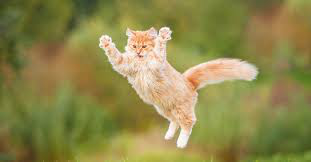

In [ ]:
draw = PIL.ImageDraw.Draw(PIL.Image.open("/content/images.jpg"))
for box in output.xyxy[0][:,:4]:
    draw.rectangle(box.tolist(), outline='red')
del draw
# PIL.Image.open(draw)
PIL.Image.open("/content/images.jpg").show()


In [ ]:
outputs.ims[0].shape

(480, 640, 3)

{'create': 251,
 'show': 0,
 'capture': 9487,
 'img': ''}
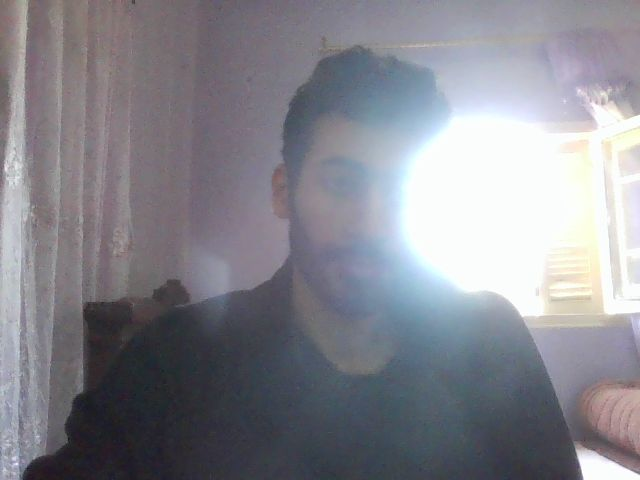

In [ ]:
js_reply

''
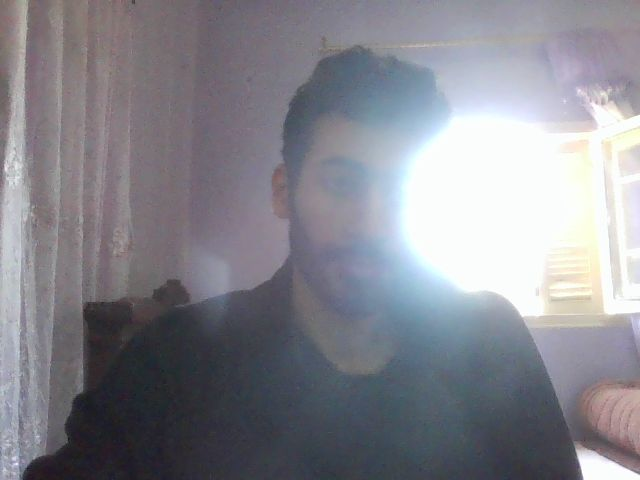

In [ ]:
js_reply["img"]

In [ ]:
js_img = js_to_image(js_reply["img"])
js_img.shape , type(js_img)

((480, 640, 3), numpy.ndarray)

In [ ]:
pil_img = PIL.Image.fromarray(js_img)
model(pil_img).xyxy[0][:,:4]

tensor([[ 23.12753,  45.05888, 599.21570, 480.00000]])

In [ ]:
for (x,y,w,h , _ ,_) in outputs.xywh[0]:
      print( x.item(),y,w,h )

368.74127197265625 tensor(304.50034) tensor(497.46817) tensor(346.82397)
609.2073364257812 tensor(426.73587) tensor(60.54773) tensor(98.25879)


# Conclusion

### In this notebook we used video stream from webcam to detect the objects in each frame using the pretrained model `YOLO` from pytorch 

## Problems I faced

### As it was the first time for me to do such thing I faced some problems that needed alot of debugging the :
* Capturing the images from the video stream
>> I used the code provided in this [notebook](https://github.com/theAIGuysCode/colab-webcam/blob/main/colab_webcam.ipynb) and with some tweaks I managed to get it to work

* The output of the model used has a variety of shapes be careful which one you implement with `cv2.rectangle() `
>> Apperantly when you choose `xyxy` as output shape it gives you the `x,y` of the middle of the object for some reason *Not Sure Why*




# Thank You 
